In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Basic Analytics
Let's first conduct some basic analytics and get an overview of the data.


In [2]:
puzzle = pd.read_csv('/content/puzzle.csv', header = None)
puzzle.columns = ['col_1', 'col_2']
print(puzzle.head(10))
print('\n')
print(puzzle.describe())
print('\n')
print(puzzle.info())

      col_1     col_2
0  0.397150  2.113629
1  0.397150  2.113629
2  0.397150  2.113629
3  0.397150  2.113629
4  0.397150  2.113629
5  0.397150  2.113629
6  0.397150  2.113629
7  0.397150  2.113629
8  0.967562 -0.099246
9  0.061841 -1.333110


             col_1        col_2
count  1024.000000  1024.000000
mean      0.504729    -0.388165
std       0.355107     1.499346
min      -0.925070    -2.837888
25%       0.389721    -1.559228
50%       0.591392    -1.129903
75%       0.746583     0.578621
max       1.195399     3.096964


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col_1   1024 non-null   float64
 1   col_2   1024 non-null   float64
dtypes: float64(2)
memory usage: 16.1 KB
None


At first sight, if someone doesn't know Hopper, there is not much things we can derive from this data. However, since I know that Hopper is a travel app and one of its feature is predicting flight prices, these could well be coordinates (lon - lat). Most likely airports coordinates.

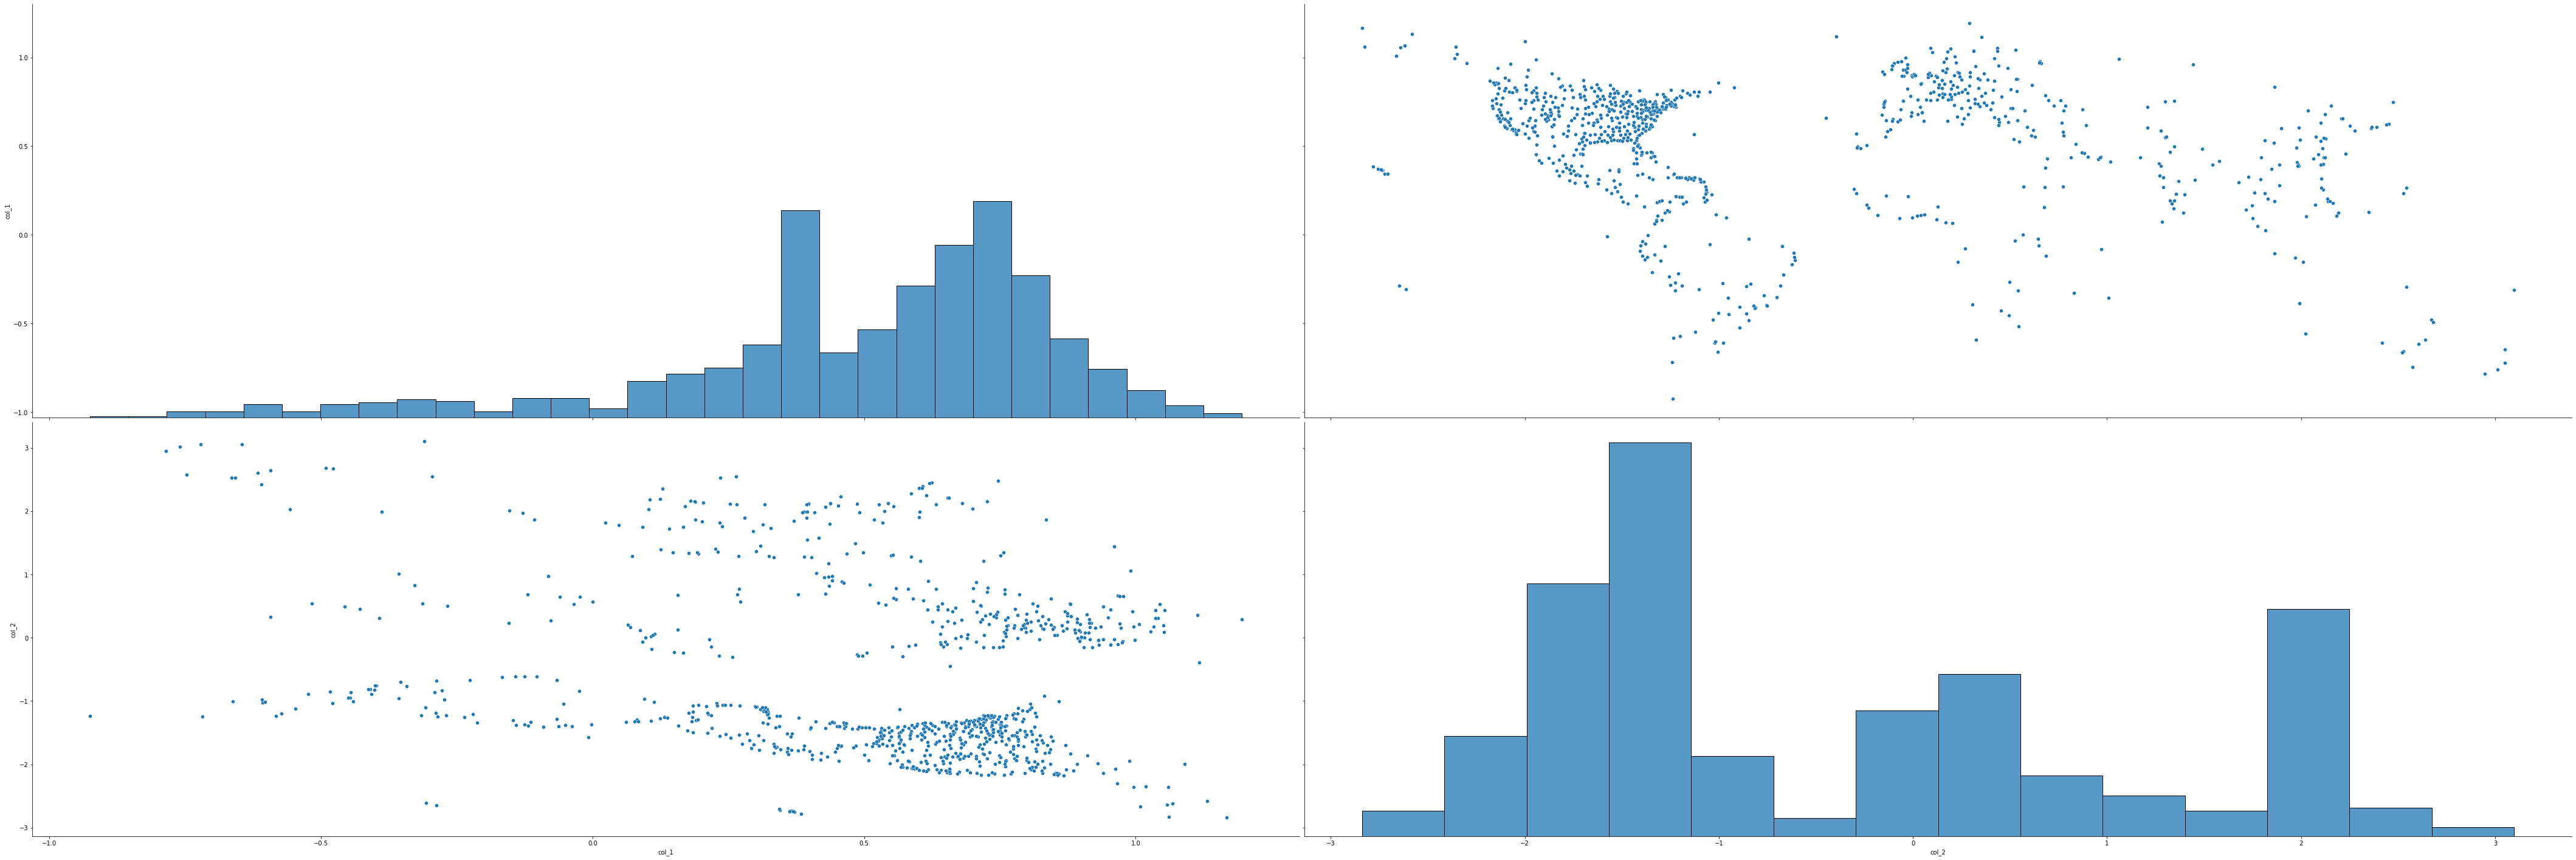

In [3]:
#I will first be using seaborn.pairplot just to visualize these data points and check if my first assumption is correct.
sns.pairplot(puzzle, aspect = 3, height = 10)

When looking the upper right scatter plot, it is pretty obvious that this looks like the world map.

That being said, what is this data really trying to tell us? When looking at the dataset, there are many duplicates which means some of the locations have been recorded many times. My first guess is that Hopper is trying to understand its users; where is the demand - most popular destinations. This would certainly help in personalizing offers and offer better services.

Now, let's dig into that and find out the locations with the most entrie (most popular).

# Mapping coordinates with airports
If we can map each given coordinate with an airport, then we'll be able to see where travellers usually fly.

In [4]:
# Firstly, I uploaded the airports dataset from "ourairports.com". It contains all we need to do our mapping.
# Let's quickly check out this dataset
airports = pd.read_csv('/content/airports.csv')
print(airports.head())
print('\n')
print(airports.info())

       id ident           type  ... home_link  wikipedia_link  keywords
0    6523   00A       heliport  ...       NaN             NaN       NaN
1  323361  00AA  small_airport  ...       NaN             NaN       NaN
2    6524  00AK  small_airport  ...       NaN             NaN       NaN
3    6525  00AL  small_airport  ...       NaN             NaN       NaN
4    6526  00AR         closed  ...       NaN             NaN      00AR

[5 rows x 18 columns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60992 entries, 0 to 60991
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 60992 non-null  int64  
 1   ident              60992 non-null  object 
 2   type               60992 non-null  object 
 3   name               60992 non-null  object 
 4   latitude_deg       60992 non-null  float64
 5   longitude_deg      60992 non-null  float64
 6   elevation_ft       50700 non-null  float64
 7

In [5]:
# For mapping purposes, I will only keep 4 decimal for the longitude and latitude.
airports.latitude_deg = round(airports.latitude_deg, 4)
airports.longitude_deg = round(airports.longitude_deg, 4)

In [6]:
# There are many columns that we do not need, so let's throw them away and only keep
# "ident", "type", "name", "latitude_deg", "longitude_deg", "iso_country", "iso_region", "municipality" and "iata_code"
/
airports_keep = airports[["ident","type", "name", "latitude_deg", "longitude_deg", "iso_country", "iso_region", "municipality", "iata_code"]]
airports_keep.head()

,ident,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,iata_code
0,00A,heliport,Total Rf Heliport,40.0708,-74.9336,US,US-PA,Bensalem,NaN
1,00AA,small_airport,Aero B Ranch Airport,38.7040,-101.4739,US,US-KS,Leoti,NaN
2,00AK,small_airport,Lowell Field,59.9492,-151.6960,US,US-AK,Anchor Point,NaN
3,00AL,small_airport,Epps Airpark,34.8648,-86.7703,US,US-AL,Harvest,NaN
4,00AR,closed,Newport Hospital & Clinic Heliport,35.6087,-91.2549,US,US-AR,Newport,NaN


Cool! Now that we have only what we need, the latitude and longitude are expressed in decimal degrees, whereas our coordinates looks like they are in radians. 
To do the actual mapping, we need to compare apples and apples, so let's convert the radians in degrees. To do that, we can simply use this formula: ***radian * 180/pi***

In [7]:
import math
puzzle = puzzle.copy()
puzzle['latitude'] = puzzle.col_2 * (180/math.pi)
puzzle['longitude'] = puzzle.col_1 * (180/math.pi)

In [8]:
puzzle.head()

,col_1,col_2,latitude,longitude
0,0.39715,2.113629,121.101998,22.755002
1,0.39715,2.113629,121.101998,22.755002
2,0.39715,2.113629,121.101998,22.755002
3,0.39715,2.113629,121.101998,22.755002
4,0.39715,2.113629,121.101998,22.755002


In [9]:
puzzle.latitude = round(puzzle.latitude, 4)
puzzle.longitude = round(puzzle.longitude, 4)

In [10]:
print(puzzle.head(10))

      col_1     col_2  latitude  longitude
0  0.397150  2.113629  121.1020    22.7550
1  0.397150  2.113629  121.1020    22.7550
2  0.397150  2.113629  121.1020    22.7550
3  0.397150  2.113629  121.1020    22.7550
4  0.397150  2.113629  121.1020    22.7550
5  0.397150  2.113629  121.1020    22.7550
6  0.397150  2.113629  121.1020    22.7550
7  0.397150  2.113629  121.1020    22.7550
8  0.967562 -0.099246   -5.6864    55.4372
9  0.061841 -1.333110  -76.3816     3.5432


Now let's do the mapping. To do that, I will try to keep 4 decimal and join the two tables using the longitudes and latitudes.

In [11]:
df_mapping = pd.merge(puzzle, airports_keep, how = 'left', left_on = ['latitude', 'longitude'], right_on = ['longitude_deg', 'latitude_deg'])

In [12]:
df_mapping.head(10)

,col_1,col_2,latitude,longitude,ident,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality,iata_code
0,0.397150,2.113629,121.1020,22.7550,RCFN,medium_airport,Taitung Airport,22.7550,121.1020,TW,TW-TTT,Taitung City,TTT
1,0.397150,2.113629,121.1020,22.7550,RCFN,medium_airport,Taitung Airport,22.7550,121.1020,TW,TW-TTT,Taitung City,TTT
2,0.397150,2.113629,121.1020,22.7550,RCFN,medium_airport,Taitung Airport,22.7550,121.1020,TW,TW-TTT,Taitung City,TTT
3,0.397150,2.113629,121.1020,22.7550,RCFN,medium_airport,Taitung Airport,22.7550,121.1020,TW,TW-TTT,Taitung City,TTT
4,0.397150,2.113629,121.1020,22.7550,RCFN,medium_airport,Taitung Airport,22.7550,121.1020,TW,TW-TTT,Taitung City,TTT
5,0.397150,2.113629,121.1020,22.7550,RCFN,medium_airport,Taitung Airport,22.7550,121.1020,TW,TW-TTT,Taitung City,TTT
6,0.397150,2.113629,121.1020,22.7550,RCFN,medium_airport,Taitung Airport,22.7550,121.1020,TW,TW-TTT,Taitung City,TTT
7,0.397150,2.113629,121.1020,22.7550,RCFN,medium_airport,Taitung Airport,22.7550,121.1020,TW,TW-TTT,Taitung City,TTT
8,0.967562,-0.099246,-5.6864,55.4372,EGEC,medium_airport,Campbeltown Airport,55.4372,-5.6864,GB,GB-SCT,Campbeltown,CAL
9,0.061841,-1.333110,-76.3816,3.5432,SKCL,medium_airport,Alfonso Bonilla Aragon International Airport,3.5432,-76.3816,CO,CO-VAC,Cali,CLO


In [13]:
df_mapping.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1024 entries, 0 to 1023
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   col_1          1024 non-null   float64
 1   col_2          1024 non-null   float64
 2   latitude       1024 non-null   float64
 3   longitude      1024 non-null   float64
 4   ident          1001 non-null   object 
 5   type           1001 non-null   object 
 6   name           1001 non-null   object 
 7   latitude_deg   1001 non-null   float64
 8   longitude_deg  1001 non-null   float64
 9   iso_country    1000 non-null   object 
 10  iso_region     1001 non-null   object 
 11  municipality   1001 non-null   object 
 12  iata_code      996 non-null    object 
dtypes: float64(6), object(7)
memory usage: 112.0+ KB


From the info that we get, out of the 1024 entries of our original table, we were able to map 1001 of them, which is about 97.8% of our total dataset. I kept only 4 decimal places since the location accuracy wouldn't change so much. In fact, from the GIS (Geographic Information System), keeping 4 decimal places ensures of an accuracy of 11.1m at the equator and accuracy for longitude increases the closer we get to the poles. For latitude, accuracy decreases but unsignificantly.
https://support.oxts.com/hc/en-us/articles/115002885125-Level-of-Resolution-of-Longitude-and-Latitude-Measurements 



# Deeper Analysis
Awesome! now that we have a mapping table, let's dig right into it and try to answer our first assumption!

In [14]:
df_unique = df_mapping['iata_code'].value_counts().reset_index()

In [15]:
df_unique = df_unique.rename(columns = {'iata_code': 'Counts'} )
df_unique

,index,Counts
0,TTT,101
1,NAP,2
2,OPO,2
3,PMI,2
4,SOF,2
...,...,...
879,PRG,1
880,OKC,1
881,VLD,1
882,AVV,1


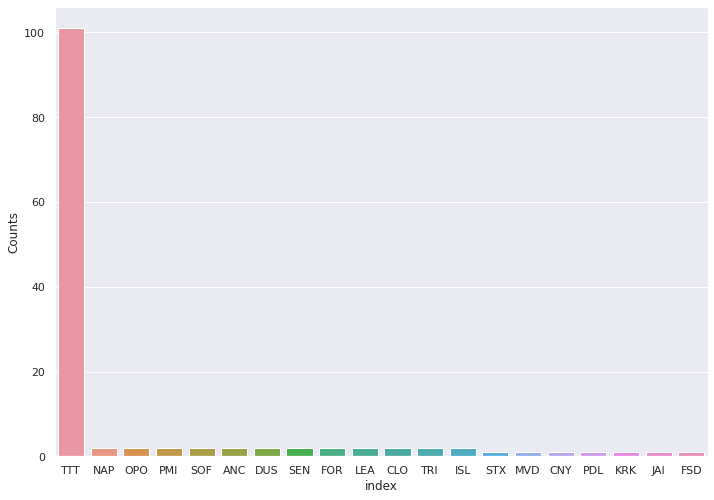

In [16]:
# Let's first check out the count for the top 20 airport by using a bar chart.
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x = df_unique['index'][:20], y = df_unique['Counts'][:20])

From the previous graph, we can see that Taitun airport is by far the one that has been recorded the most. 

In [ ]:
# This cell is used to download Basemap
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6


In [17]:
from mpl_toolkits.basemap import Basemap

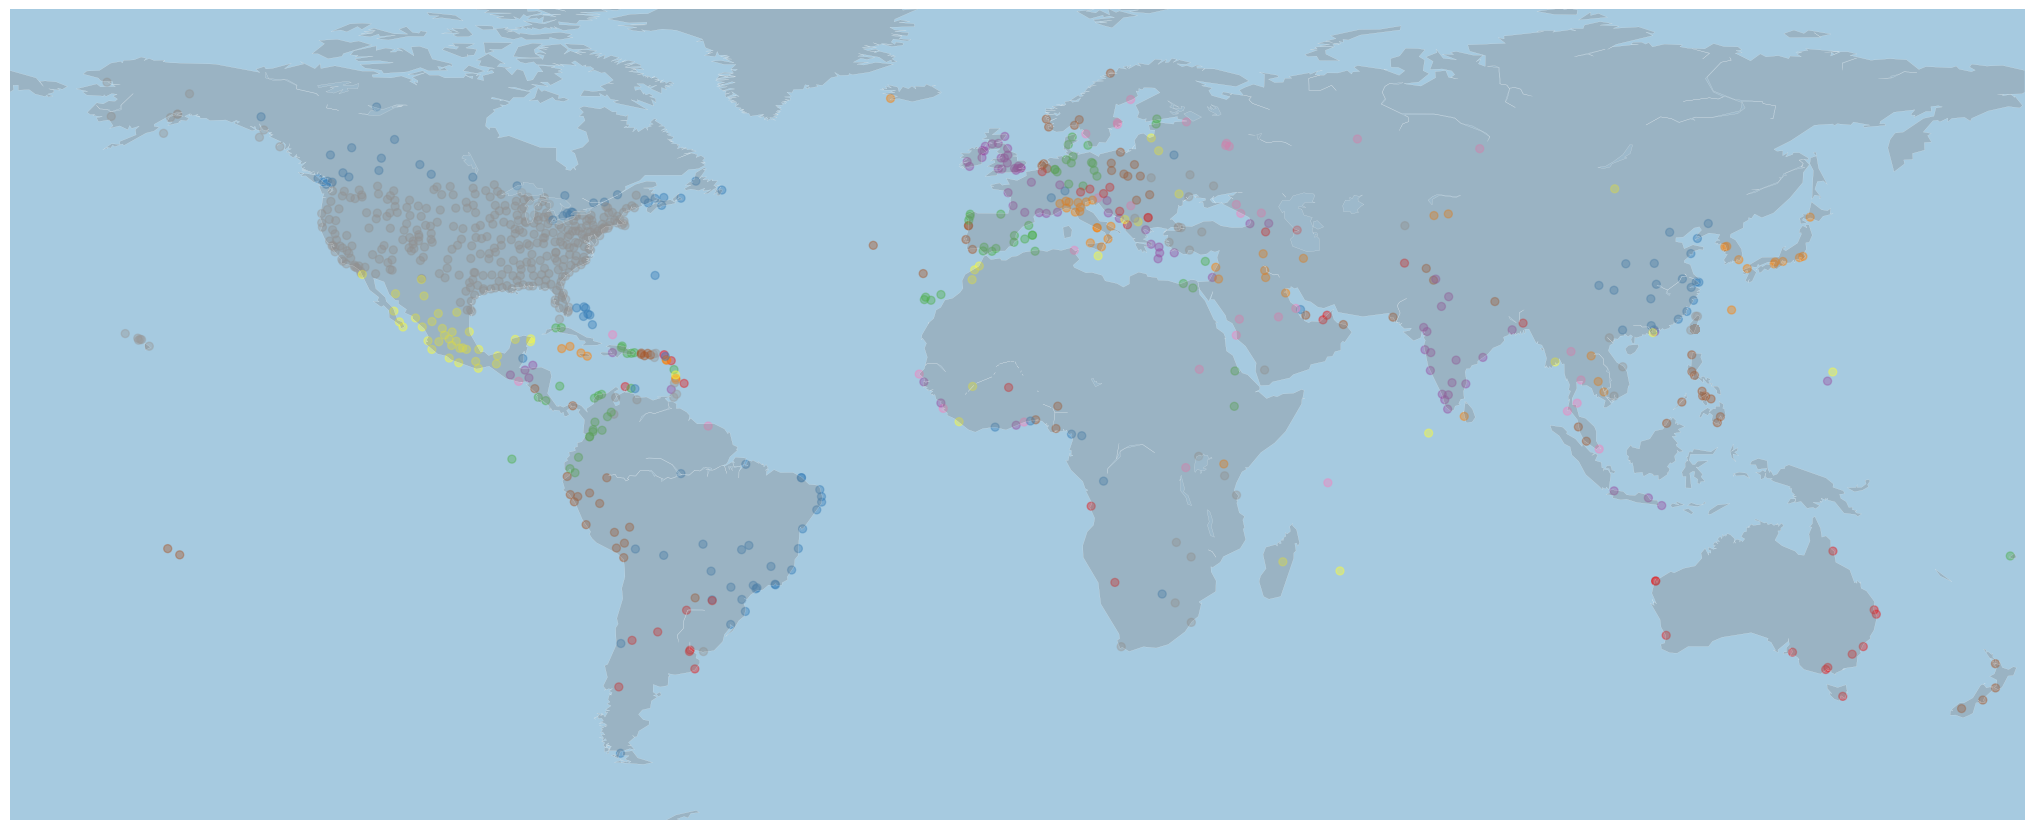

In [18]:
# Let's have a look on the world map using bubbles
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
# prepare a color for each point depending on the continent.
df_mapping['labels_enc'] = pd.factorize(df_mapping['iso_country'], sort = True)[0]
# Add a point per position
m.scatter(df_mapping['longitude_deg'], df_mapping['latitude_deg'], alpha=0.4, c=df_mapping['labels_enc'], cmap="Set1")


From the above map, we can clearly see that the US contains the majority of the coordinates entries from the data set. Even though Taitung airport is the one that has been recorded the most, the US still has a higher concentration of airports.

Let's just quickly check the ratios for each of the top 5 countries in terms of airports counts.

In [19]:
top_countries = df_mapping['iso_country'].value_counts(normalize = True).reset_index()
top_countries[:6]

,index,iso_country
0,US,0.361
1,TW,0.104
2,CA,0.036
3,MX,0.035
4,BR,0.026
5,CN,0.020


The US has 36.1% of the total entries, compared to 10.4% for Taiwan. My first assumption was that Hopper is trying to do some segmentation and figure out which country is the biggest market in order to develop it further.

However, I am still skeptical about Taitung airport. It has many entries and I have never heard of it before. Although this could be a popular destination within Asia, it could also well be a cheaper airport to fly in or out. I know for a fact that Taiwan is an international hub for connecting passengers, maybe it is a cheaper alternative than transiting in Tapei. However, Taitung airport is quite small and currently, it only serves domestic flights. From a quick research, it looks like only two airlines fly to this city: Uni air and Mandarin airlines. Flight tickets are quite cheap.

My final assumption is that since Hopper predicts and analyzes airfare, this puzzle could try to tell us the most popular affordable destination airports where people fly to among the ones that booked via the Hopper app. 

That being said, it would be interesting to have more data and add in a couple of variables such as a timestamp, cabin compartments, etc.  